In [1]:
file_path = "../f4.xlsx"

In [2]:
import pandas as pd

df = pd.read_excel(file_path)
df.to_csv('output.csv', index=False)

In [3]:
df.head()

,Wait,x_ArrivalDTTM,x_ScheduledDTTM,x_BeginDTTM,SumWaits,LineCount0,LineCount1,LineCount2,LineCount3,LineCount4,...,NumCompletedInLastW3,NumCustomersInLastW1,NumCustomersInLastW2,NumCustomersInLastW3,AvgWaitLastW1,AvgWaitLastW2,AvgWaitLastW3,AvgWaitForDay,OutpatientWaitingCount,MalesWaitingCount
0,3,2025-07-20 18:32:03,2025-07-20 18:35:00,2025-07-20 18:35:15,0,0,0,0,0,0,...,8,2,2,4,2,2,2,5.862319,1,0
1,2,2025-07-20 18:14:02,2025-07-20 18:15:00,2025-07-20 18:16:00,0,0,0,0,1,0,...,8,1,3,9,0,2,2,5.890511,1,1
2,1,2025-07-20 17:28:52,2025-07-20 17:30:00,2025-07-20 17:29:19,0,0,0,0,0,1,...,19,2,3,15,4,3,2,5.926471,1,0
3,4,2025-07-20 17:20:20,2025-07-20 17:20:00,2025-07-20 17:24:09,0,0,0,0,0,0,...,21,1,5,16,0,2,2,5.940741,1,0
4,2,2025-07-20 16:31:15,2025-07-20 16:35:00,2025-07-20 16:33:43,0,0,2,1,0,1,...,29,6,12,28,2,2,4,5.970149,1,0


In [4]:
# Prepare relevant features and target
df = df[["x_ArrivalDTTM", "DayOfWeek", "Month", "DayOfYear"]]
df.head()


,x_ArrivalDTTM,DayOfWeek,Month,DayOfYear
0,2025-07-20 18:32:03,5.0,7.0,199.0
1,2025-07-20 18:14:02,5.0,7.0,199.0
2,2025-07-20 17:28:52,5.0,7.0,199.0
3,2025-07-20 17:20:20,5.0,7.0,199.0
4,2025-07-20 16:31:15,5.0,7.0,199.0


In [5]:
df["timestamp"] = pd.to_datetime(df["x_ArrivalDTTM"])

In [6]:
ts = (
    df
    .set_index("timestamp")
    .resample("H")
    .size()                  # counts rows per hour
    .rename("arrivals")      # name the resulting Series
)

C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16332\3538339812.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H")


In [7]:
import numpy as np

# 2. Build Features DataFrame
# ----------------------------
max_lag = 168     # past week
horizons = 24     # next 1…24 hours

# initialize feature frame indexed by the same hours
X = pd.DataFrame(index=ts.index)

# a) Lag features
for lag in range(1, max_lag + 1):
    X[f"lag_{lag}"] = ts.shift(lag)

# b) Rolling statistics (exclude the current hour by shifting 1)
X["rolling_mean_3"]  = ts.shift(1).rolling(3).mean()
X["rolling_std_24"]  = ts.shift(1).rolling(24).std()

# c) Calendar features
X["hour_of_day"]  = X.index.hour
X["day_of_week"]  = X.index.dayofweek

# d) Cyclical encodings
t = X["hour_of_day"]
X["sin_hour"] = np.sin(2 * np.pi * t / 24)
X["cos_hour"] = np.cos(2 * np.pi * t / 24)

doy = X.index.dayofyear
X["sin_doy"] = np.sin(2 * np.pi * doy / 365.25)
X["cos_doy"] = np.cos(2 * np.pi * doy / 365.25)



C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16332\864559791.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"lag_{lag}"] = ts.shift(lag)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16332\864559791.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"lag_{lag}"] = ts.shift(lag)
C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16332\864559791.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

In [8]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_167,lag_168,rolling_mean_3,rolling_std_24,hour_of_day,day_of_week,sin_hour,cos_hour,sin_doy,cos_doy
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-30 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8,3,8.660254e-01,-5.000000e-01,-0.512055,0.858953
2023-11-30 09:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9,3,7.071068e-01,-7.071068e-01,-0.512055,0.858953
2023-11-30 10:00:00,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10,3,5.000000e-01,-8.660254e-01,-0.512055,0.858953
2023-11-30 11:00:00,17.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10.333333,NaN,11,3,2.588190e-01,-9.659258e-01,-0.512055,0.858953
2023-11-30 12:00:00,12.0,17.0,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.000000,NaN,12,3,1.224647e-16,-1.000000e+00,-0.512055,0.858953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-20 14:00:00,10.0,19.0,26.0,23.0,16.0,4.0,0.0,0.0,0.0,0.0,...,17.0,8.0,18.333333,8.914144,14,6,-5.000000e-01,-8.660254e-01,-0.310857,-0.950457
2025-07-20 15:00:00,16.0,10.0,19.0,26.0,23.0,16.0,4.0,0.0,0.0,0.0,...,8.0,17.0,15.000000,8.802071,15,6,-7.071068e-01,-7.071068e-01,-0.310857,-0.950457
2025-07-20 16:00:00,15.0,16.0,10.0,19.0,26.0,23.0,16.0,4.0,0.0,0.0,...,2.0,8.0,13.666667,8.637213,16,6,-8.660254e-01,-5.000000e-01,-0.310857,-0.950457


In [9]:
y = pd.concat(
    [ ts.shift(-h).rename(f"y{h}") for h in range(1, horizons + 1) ],
    axis=1
)

In [10]:
y.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-30 08:00:00,13.0,17.0,12.0,14.0,9.0,13.0,13.0,11.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-11-30 09:00:00,17.0,12.0,14.0,9.0,13.0,13.0,11.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0
2023-11-30 10:00:00,12.0,14.0,9.0,13.0,13.0,11.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,21.0
2023-11-30 11:00:00,14.0,9.0,13.0,13.0,11.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,21.0,21.0
2023-11-30 12:00:00,9.0,13.0,13.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,15.0,21.0,21.0,15.0


In [11]:
data = pd.concat([X, y], axis=1)
data = data.dropna()       # remove rows where any feature/target is NaN

In [12]:
data.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-07 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2023-12-07 09:00:00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,18.0
2023-12-07 10:00:00,14.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,18.0,16.0
2023-12-07 11:00:00,18.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,18.0,16.0,24.0
2023-12-07 12:00:00,16.0,18.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,18.0,16.0,24.0,23.0


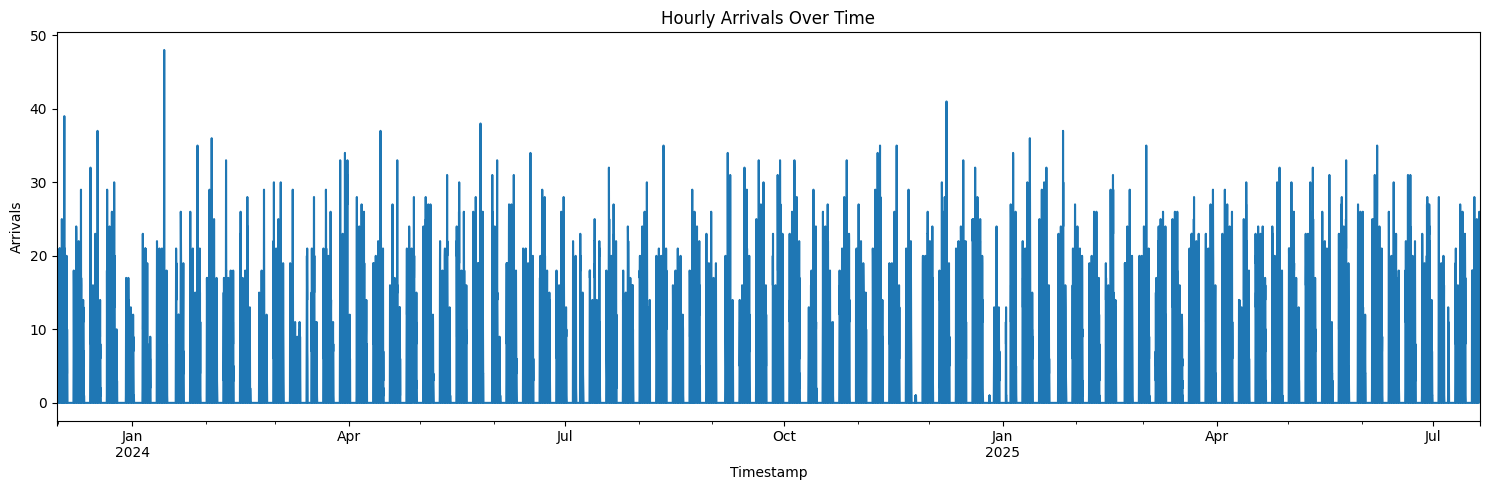

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
ts.plot()
plt.title("Hourly Arrivals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Arrivals")
plt.tight_layout()
plt.show()

# Training

## LGBM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Assume `y_val` and `val_preds` are already defined in the environment
# y_val: DataFrame of true values with columns y1…y24
# val_preds: DataFrame of predicted values with the same columns

# Calculate MAE, RMSE, MAPE for each horizon
metrics = []
for h in y_val.columns:
    y_true = y_val[h]
    y_pred = val_preds[h]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    # Handle division by zero in MAPE
    mape = (np.abs((y_true - y_pred) / y_true).replace([np.inf, -np.inf], np.nan) * 100).mean()
    metrics.append({"horizon": h, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape})

metrics_df = pd.DataFrame(metrics).set_index("horizon")

# Print per-horizon metrics
print("Validation Metrics by Horizon:")
print(metrics_df)

# Overall average metrics across horizons
overall = {
    "MAE": metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "MAPE (%)": metrics_df["MAPE (%)"].mean()
}

print("\nOverall Validation Metrics:")
print(f"MAE: {overall['MAE']:.3f}")
print(f"RMSE: {overall['RMSE']:.3f}")
print(f"MAPE: {overall['MAPE (%)']:.2f}%")


Validation Metrics by Horizon:
              MAE      RMSE   MAPE (%)
horizon                               
y1       1.039528  2.472053  38.404056

Overall Validation Metrics:
MAE: 1.040
RMSE: 2.472
MAPE: 38.40%


## LSTM

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Load & Resample to hourly arrivals ---
# df: your DataFrame with an "arrival_time" column
df["timestamp"] = pd.to_datetime(df["x_ArrivalDTTM"])
df.set_index("timestamp", inplace=True)
ts = df.resample("H").size().rename("arrivals")

# --- 2. Build time‐feature DataFrame ---
df_ts = ts.reset_index().rename(columns={"timestamp":"ts","arrivals":"count"})
df_ts["hour"]        = df_ts["ts"].dt.hour
df_ts["day_of_week"] = df_ts["ts"].dt.dayofweek
df_ts["day_of_year"] = df_ts["ts"].dt.dayofyear

# cyclical encodings
df_ts["sin_hour"] = np.sin(2*np.pi*df_ts["hour"]       / 24)
df_ts["cos_hour"] = np.cos(2*np.pi*df_ts["hour"]       / 24)
df_ts["sin_dow"]  = np.sin(2*np.pi*df_ts["day_of_week"] / 7)
df_ts["cos_dow"]  = np.cos(2*np.pi*df_ts["day_of_week"] / 7)
df_ts["sin_doy"]  = np.sin(2*np.pi*df_ts["day_of_year"] / 365.25)
df_ts["cos_doy"]  = np.cos(2*np.pi*df_ts["day_of_year"] / 365.25)

# --- 3. Scale features ---
feature_cols = ["count","sin_hour","cos_hour","sin_dow","cos_dow","sin_doy","cos_doy"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_ts[feature_cols])
count_min, count_max = scaler.data_min_[0], scaler.data_max_[0]

# --- 4. Create sliding windows (168 → 24) ---
window_size, horizon = 168, 24
X, Y = [], []
for i in range(len(scaled) - window_size - horizon + 1):
    X.append(scaled[i : i + window_size, :])                 # (window_size, 7)
    Y.append(scaled[i + window_size : i + window_size + horizon, 0])  # only "count"
X = np.stack(X)  # shape = (n_samples, 168, 7)
Y = np.stack(Y)  # shape = (n_samples, 24)

# --- 5. Train/Validation Split ---
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)

# --- 6. DataLoaders ---
batch_size = 32
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(Y_train, dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val,   dtype=torch.float32),
                         torch.tensor(Y_val,   dtype=torch.float32))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

# --- 7. Define the LSTM Model ---
class MultiFeatureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, horizon=24):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc   = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiFeatureLSTM(input_size=len(feature_cols), hidden_size=64, horizon=horizon).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 8. Training Loop ---
epochs = 100
for epoch in range(1, epochs+1):
    # train
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # validate
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred   = model(xb)
            val_losses.append(criterion(pred, yb).item())
    print(f"Epoch {epoch}/{epochs} — train MAE: {np.mean(train_losses):.4f}, val MAE: {np.mean(val_losses):.4f}")

# --- 9. Inference Example ---
model.eval()
with torch.no_grad():
    sample = torch.tensor(X_val[-1:], dtype=torch.float32).to(device)
    scaled_pred = model(sample).cpu().numpy()  # shape (1, 24)
    # invert only the "count" scaling
    inv = scaled_pred * (count_max - count_min) + count_min
    print("Forecast next 24h arrivals:", inv.flatten())


C:\Users\Gigabyte\AppData\Local\Temp\ipykernel_16332\3551124838.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df.resample("H").size().rename("arrivals")


Epoch 1/100 — train MAE: 0.0635, val MAE: 0.0521
Epoch 2/100 — train MAE: 0.0401, val MAE: 0.0409
Epoch 3/100 — train MAE: 0.0343, val MAE: 0.0379
Epoch 4/100 — train MAE: 0.0326, val MAE: 0.0364
Epoch 5/100 — train MAE: 0.0316, val MAE: 0.0348
Epoch 6/100 — train MAE: 0.0308, val MAE: 0.0332
Epoch 7/100 — train MAE: 0.0302, val MAE: 0.0328
Epoch 8/100 — train MAE: 0.0297, val MAE: 0.0320
Epoch 9/100 — train MAE: 0.0292, val MAE: 0.0321
Epoch 10/100 — train MAE: 0.0289, val MAE: 0.0313
Epoch 11/100 — train MAE: 0.0285, val MAE: 0.0310
Epoch 12/100 — train MAE: 0.0282, val MAE: 0.0309
Epoch 13/100 — train MAE: 0.0279, val MAE: 0.0304
Epoch 14/100 — train MAE: 0.0277, val MAE: 0.0303
Epoch 15/100 — train MAE: 0.0274, val MAE: 0.0298
Epoch 16/100 — train MAE: 0.0273, val MAE: 0.0294
Epoch 17/100 — train MAE: 0.0271, val MAE: 0.0291
Epoch 18/100 — train MAE: 0.0270, val MAE: 0.0285
Epoch 19/100 — train MAE: 0.0269, val MAE: 0.0283
Epoch 20/100 — train MAE: 0.0268, val MAE: 0.0280
Epoch 21/

Save model

In [15]:
# 1. Save PyTorch model’s state_dict (recommended)
import torch

# After training completes:
model_path = "model.pt"
torch.save(model.state_dict(), model_path)
print(f"Saved model state_dict to {model_path}")

# 2. (Optional) Save the entire model (including architecture)
full_model_path = "model_full.pth"
torch.save(model, full_model_path)
print(f"Saved full model to {full_model_path}")

# 3. Save the scaler object with pickle
import pickle

scaler_path = "scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")


Saved model state_dict to model.pt
Saved full model to model_full.pth
Saved scaler to scaler.pkl
